# 实现基于协方差矩阵的PCA
## 目录

## 基于协方差矩阵的PCA原理

参考资料：
http://blog.codinglabs.org/articles/pca-tutorial.html  
文章写的太好了
寻找一维基：
还是寻找一维基，使得所有数据变换（即投影）后，方差尽可能大
$$Var(a) = \frac{1}{m}\sum\limits_{i=1}^ma_i^2$$

寻找第二维基：
我们希望让这两个字段尽可能表示更多的原始信息，所以我们希望他们是（线性）无关的  
字段的相关性可以用两个字段的协方差来表示。

----
协方差
$$Cov(a,b) = \frac{1}{m} E\big( (X-EX)(Y-EY) \big)$$
因为我们在进行PCA之前会对数据进行去均值化，故
$$Cov(a,b) = E(XY) = \frac{1}{m}\sum\limits_{i=1}^ma_ib_i$$
将一组N维向量降到K维，目标是选择K个单位正交基，使得原始数据变换到这组基上后，各字段两两协方差为0，字段的方差尽可能大（正交约束下，取最大的K各方差）

----
协方差矩阵
$\frac{1}{m}X^TX$正好可以求出X每两个特征之间的协方差
设协方差矩阵为$C = \frac{1}{m}X^TX$
C是一个对称矩阵，其对角线上分别为各个字段的方差，而第i行第j列的元素表示i和j字段的协方差

-----
协方差矩阵对角化
我们的目标就是让协方差矩阵对角化，即除对角线外的其他元素化为0（两两无关),且对角线上的元素按从大到小排列  
设满足这个要求的目标矩阵为Y，即变换后的矩阵  
则$\frac{1}{m}Y^TY$是对角阵   
故$\Lambda = \frac{1}{m}Y^TY$  
因为Y 是由 X空间变换而来，故假设变换到的空间的基向量矩阵为P  
故$Y^T = P^{(-1)}X^T$

$$\begin{aligned}
\Lambda & = \frac{1}{m}P^{(-1)}X^TX(P^{(-1)})^T \\ 
& = P^{(-1)}C(P^{(-1)})^T 
\end{aligned}
$$

我们要找的即是让C矩阵对角化的矩阵。    
由于C矩阵是是对称矩阵，故可以得到n个单位正交特征向量  
$E^TCE = \Lambda$

故$P^{(-1)} = E^T$  
$P = E$(因为E是标准正交矩阵，$E^T = E^{(-1)}$)

具体操作：
* 求出X的协方差矩阵C
* 求出C的特征值和特征向量
* $\Lambda$中的特征值按从大到小摆放，P为对应的单位正交特征向量
----
PCA算法
* X矩阵去均值
* 求出X的协方差矩阵$C= \frac{1}{m}X^TX$
* 求出C的特征值和对应的特征向量
* 将特征向量对应的特征值从大到小按列排列成矩阵，取前k列组成矩阵P
* Y = P^{(-1)}X即为降维到k维的数据

In [1]:
## 实现基于协方差矩阵的PCA
import numpy as np
class PCA_cov():
    
    def __init__(self,n_component):
        self.n_components = n_component
        self.W = None
        
    def fit(self,X):
        X = X - X.mean(axis=0) #去均值化
        C = X.T.dot(X)/len(X) #求协方差矩阵
        v,w = np.linalg.eig(C) #求协方差矩阵的特征值和特征向量
        index = np.argsort(v)[::-1]#将特征值有大到小排列
        self.W = w[:,index[:self.n_components]] #W即为前n_components特征向量
    
    def transform(self,X):
        assert self.W is not None,"fit before transform"
        return X.dot(self.W)
    
    def reverse_transform(self,X):
        return X.dot(self.W.T)

## 自制数据集进行验证

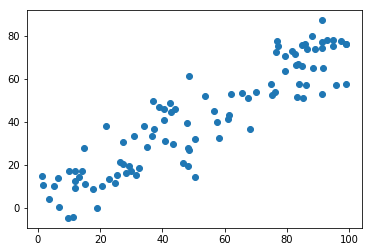

In [4]:
import numpy as np
X = np.empty(shape=(100,2))
X[:,0] = np.random.uniform(0,100,size=100)
X[:,1] = X[:,0]*0.75 + 3 + np.random.normal(0,10,size=100)
import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1])

In [5]:
pca = PCA_cov(n_component=1)
pca.fit(X)
Y = pca.transform(X)
X_new = pca.reverse_transform(Y)

In [6]:
pca.n_components

1

In [7]:
pca.W

array([[0.78003446],
       [0.62573656]])

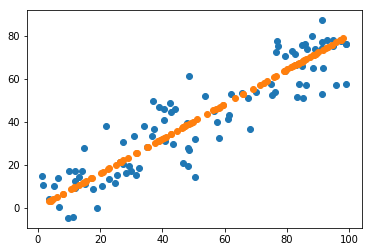

In [8]:
plt.scatter(X[:,0],X[:,1])
plt.scatter(X_new[:,0],X_new[:,1])

## PCA的能力和限制
PCA对于存在高阶相关性的数据就没有办法了，可以考虑Kernel PCA,通过Kernel函数将非线性相关转化为线性相关。  
另外PCA假设数据各主特征是分布在正交方向上，如果在非正交方向上存在几个方差较大的方向，那么PCA的效果就大打折扣